In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

import kontrol
import vishack


seis_data1 = vishack.data.diaggui.Diaggui("../data/quiet_20240222.xml")
seis_data2 = vishack.data.diaggui.Diaggui("../data/quiet_20230720.xml")
seis_data3 = vishack.data.diaggui.Diaggui("../data/lockloss_20240101.xml")
seis_data4 = vishack.data.diaggui.Diaggui("../data/lockloss_20240107.xml")
seis_data5 = vishack.data.diaggui.Diaggui("../data/lockloss_20240112.xml")

f, seis_x1 = seis_data1.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x2 = seis_data2.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x3 = seis_data3.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x4 = seis_data4.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x5 = seis_data5.psd("L1:ISI-GND_STS_ITMX_X_DQ")

_, gs13_x1 = seis_data1.psd("L1:ISI-ITMX_ST2_BLND_X_GS13_CUR_IN1_DQ")


# Calibrate to m
seis_x1 = seis_x1 * 1/(2*np.pi*f) * 1e-9  # Integrate and nm to m
seis_x2 = seis_x2 * 1/(2*np.pi*f) * 1e-9
seis_x3 = seis_x3 * 1/(2*np.pi*f) * 1e-9
seis_x4 = seis_x4 * 1/(2*np.pi*f) * 1e-9
seis_x5 = seis_x5 * 1/(2*np.pi*f) * 1e-9

s = control.tf("s")
wn = 1*2*np.pi
q = 1/np.sqrt(2)
gs13_cal = (s**2 + wn/q*s + wn**2) / (s**3)

gs13_x1 = gs13_x1 * abs(gs13_cal(1j*2*np.pi*f)) * 1e-9

# Load filters
h_sc = kontrol.load_transfer_function("../filters/CML_BB_SC.pkl")
h1 = kontrol.load_transfer_function("../filters/102mHzv2_disp.pkl")
h2 = kontrol.load_transfer_function("../filters/102mHzv2_inert.pkl")

# Undo calibration coupling in the filter
h_sc = h_sc * s  # undo integrator
h2 = h2/gs13_cal  # undo gs13 calibration filter

# Load H-infinity filters
h_sc_hinf1 = kontrol.load_transfer_function("h_sc_hinf_20240222.pkl")
h1_hinf1 = kontrol.load_transfer_function("h1_hinf_20240222.pkl")
h2_hinf1 = kontrol.load_transfer_function("h2_hinf_20240222.pkl")

h_sc_hinf4 = kontrol.load_transfer_function("h_sc_hinf_20240107.pkl")
h1_hinf4 = kontrol.load_transfer_function("h1_hinf_20240107.pkl")
h2_hinf4 = kontrol.load_transfer_function("h2_hinf_20240107.pkl")

h_sc_hinf4_2 = kontrol.load_transfer_function("h_sc_hinf_20240107_2.pkl")
h1_hinf4_2 = kontrol.load_transfer_function("h1_hinf_20240107_2.pkl")
h2_hinf4_2 = kontrol.load_transfer_function("h2_hinf_20240107_2.pkl")

h_sc_prefilter = kontrol.load_transfer_function("h_sc_prefilt.pkl")
h2_prefilter = kontrol.load_transfer_function("h2_prefilter.pkl")

h_sc_hinf1 = h_sc_hinf1 * h_sc_prefilter
h_sc_hinf4 = h_sc_hinf4 * h_sc_prefilter
h_sc_hinf4_2 = h_sc_hinf4_2 * h_sc_prefilter

h2_hinf1 = h2_hinf1 * h2_prefilter
h2_hinf4 = h2_hinf4 * h2_prefilter
h2_hinf4_2 = h2_hinf4_2 * h2_prefilter

h1_hinf1 = 1 - h2_hinf1
h1_hinf4 = 1 - h2_hinf4
h1_hinf4_2 = 1 - h2_hinf4_2


# Make noises
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise

n_seis_params2 = [1*10**-9.9, 0, 2.5, 0]
n_seis_params1 = [1*10**-9.15, 0, 2.5, 0]
n_seis_params4 = [1*10**-9.8, 0, 2.5, 0]

n_gs13_params = [1*10**-11.125, 1*10**-11.375, 3.5, 1.15]
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]

n_seis1 = lambda f: noise_model(f, *n_seis_params1)
n_seis2 = lambda f: noise_model(f, *n_seis_params2)
n_seis4 = lambda f: noise_model(f, *n_seis_params4)

n_gs13 = lambda f: noise_model(f, *n_gs13_params)
n_ade1 = lambda f: noise_model(f, *n_ade1_params)

xg1 = np.array(seis_x1)
xg1[f<0.09] = xg1[f>=0.09][0] 

xg2 = np.array(seis_x2)
xg2[f<0.08] = xg2[f>=0.08][0] 

xg4 = np.array(seis_x4)
xg4[f<0.03] = xg4[f>=0.03][0] 

In [2]:
n_seis_filtered1 = abs(h_sc(1j*2*np.pi*f)) * n_seis1(f)
n_seis_filtered2 = abs(h_sc(1j*2*np.pi*f)) * n_seis2(f)
n_seis_filtered4 = abs(h_sc(1j*2*np.pi*f)) * n_seis4(f)

# n_seis_filtered1 = abs(h_sc_hinf1(1j*2*np.pi*f)) * n_seis1(f)
# n_seis_filtered2 = abs(h_sc_hinf2(1j*2*np.pi*f)) * n_seis2(f)
# n_seis_filtered4 = abs(h_sc_hinf4(1j*2*np.pi*f)) * n_seis4(f)

xg_filtered1 = abs((1-h_sc)(1j*2*np.pi*f)) * xg1
xg_filtered2 = abs((1-h_sc)(1j*2*np.pi*f)) * xg2
xg_filtered4 = abs((1-h_sc)(1j*2*np.pi*f)) * xg4

n_sc1 = kontrol.core.math.quad_sum(n_seis_filtered1, xg_filtered1)
n_sc2 = kontrol.core.math.quad_sum(n_seis_filtered2, xg_filtered2)
n_sc4 = kontrol.core.math.quad_sum(n_seis_filtered4, xg_filtered4)

n_rel_sc1 = kontrol.core.math.quad_sum(n_ade1(f), n_sc1)
n_rel_sc2 = kontrol.core.math.quad_sum(n_ade1(f), n_sc2)
n_rel_sc4 = kontrol.core.math.quad_sum(n_ade1(f), n_sc4)

n_rel_filtered1 = abs(h1(1j*2*np.pi*f)) * n_rel_sc1
n_rel_filtered2 = abs(h1(1j*2*np.pi*f)) * n_rel_sc2
n_rel_filtered4 = abs(h1(1j*2*np.pi*f)) * n_rel_sc4

n_gs13_filtered1 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered2 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered4 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)

n_super1 = kontrol.core.math.quad_sum(n_rel_filtered1, n_gs13_filtered1)
n_super2 = kontrol.core.math.quad_sum(n_rel_filtered2, n_gs13_filtered2)
n_super4 = kontrol.core.math.quad_sum(n_rel_filtered4, n_gs13_filtered4)

In [3]:
n_seis_filtered_hinf1 = abs(h_sc_hinf1(1j*2*np.pi*f)) * n_seis1(f)
# n_seis_filtered2 = abs(h_sc(1j*2*np.pi*f)) * n_seis2(f)
n_seis_filtered_hinf4 = abs(h_sc_hinf4(1j*2*np.pi*f)) * n_seis4(f)
n_seis_filtered_hinf4_2 = abs(h_sc_hinf4_2(1j*2*np.pi*f)) * n_seis4(f)


xg_filtered_hinf1 = abs((1-h_sc_hinf1)(1j*2*np.pi*f)) * xg1
# xg_filtered_hinf2 = abs((1-h_sc)(1j*2*np.pi*f)) * xg2
xg_filtered_hinf4 = abs((1-h_sc_hinf4)(1j*2*np.pi*f)) * xg4
xg_filtered_hinf4_2 = abs((1-h_sc_hinf4_2)(1j*2*np.pi*f)) * xg4


n_sc_hinf1 = kontrol.core.math.quad_sum(n_seis_filtered_hinf1, xg_filtered_hinf1)
# n_sc_hinf2 = kontrol.core.math.quad_sum(n_seis_filtered2, xg_filtered2)
n_sc_hinf4 = kontrol.core.math.quad_sum(n_seis_filtered_hinf4, xg_filtered_hinf4)
n_sc_hinf4_2 = kontrol.core.math.quad_sum(n_seis_filtered_hinf4_2, xg_filtered_hinf4_2)


n_rel_sc_hinf1 = kontrol.core.math.quad_sum(n_ade1(f), n_sc_hinf1)
# n_rel_sc_hinf2 = kontrol.core.math.quad_sum(n_ade1(f), n_sc2)
n_rel_sc_hinf4 = kontrol.core.math.quad_sum(n_ade1(f), n_sc_hinf4)
n_rel_sc_hinf4_2 = kontrol.core.math.quad_sum(n_ade1(f), n_sc_hinf4_2)


n_rel_filtered_hinf1 = abs(h1_hinf1(1j*2*np.pi*f)) * n_rel_sc_hinf1
# n_rel_filtered_hinf2 = abs(h1(1j*2*np.pi*f)) * n_rel_sc2
n_rel_filtered_hinf4 = abs(h1_hinf4(1j*2*np.pi*f)) * n_rel_sc_hinf4
n_rel_filtered_hinf4_2 = abs(h1_hinf4_2(1j*2*np.pi*f)) * n_rel_sc_hinf4_2


n_gs13_filtered_hinf1 = abs(h2_hinf1(1j*2*np.pi*f)) * n_gs13(f)
# n_gs13_filtered2 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered_hinf4 = abs(h2_hinf4(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered_hinf4_2 = abs(h2_hinf4_2(1j*2*np.pi*f)) * n_gs13(f)


n_super_hinf1 = kontrol.core.math.quad_sum(n_rel_filtered_hinf1, n_gs13_filtered_hinf1)
# n_super2 = kontrol.core.math.quad_sum(n_rel_filtered2, n_gs13_filtered2)
n_super_hinf4 = kontrol.core.math.quad_sum(n_rel_filtered_hinf4, n_gs13_filtered_hinf4)
n_super_hinf4_2 = kontrol.core.math.quad_sum(n_rel_filtered_hinf4_2, n_gs13_filtered_hinf4_2)

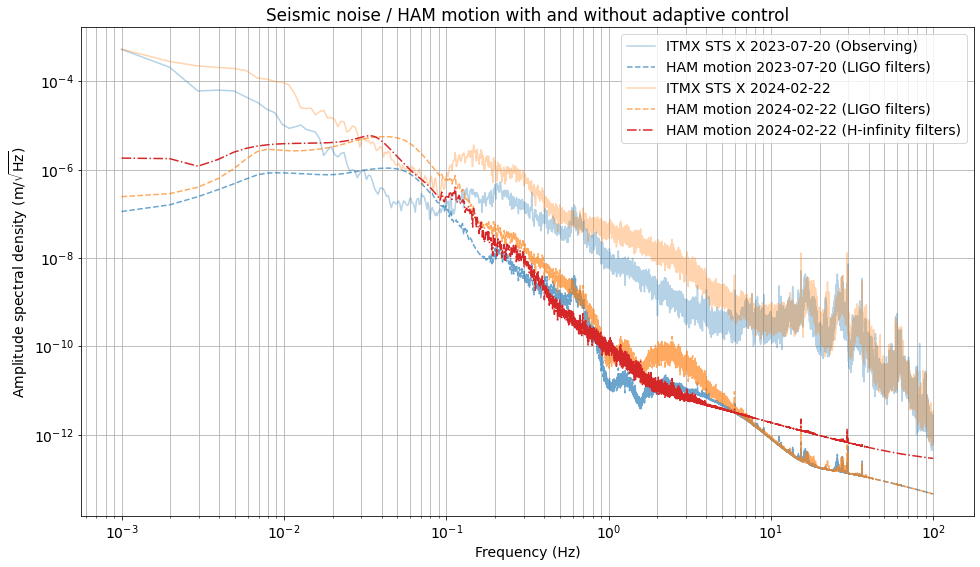

In [4]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise / HAM motion with and without adaptive control")

plt.loglog(f, seis_x2, alpha=0.33, label="ITMX STS X 2023-07-20 (Observing)")
plt.loglog(f, n_super2, "C0--", alpha=0.66, label="HAM motion 2023-07-20 (LIGO filters)")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

plt.loglog(f, seis_x1, color="C1", alpha=0.33, label="ITMX STS X 2024-02-22")
plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

# plt.loglog(f, seis_x4, color="C2", alpha=0.33, label="ITMX STS X 2024-01-07 (Microseism)")
# plt.loglog(f, n_super4, "C2--", alpha=0.66, label="HAM motion 2024-01-07 (LIGO filters)")
# plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240222.png", bbox_inches="tight")

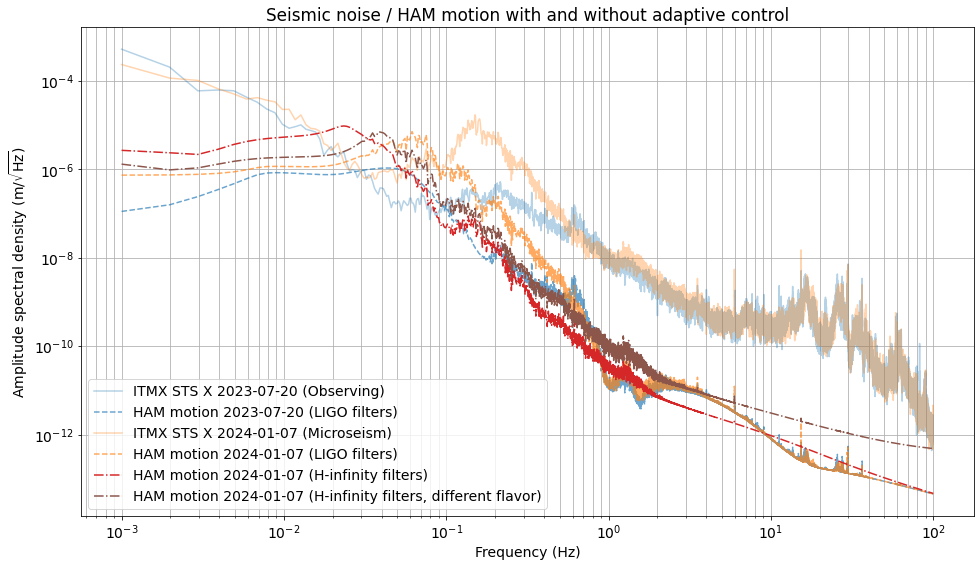

In [5]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise / HAM motion with and without adaptive control")

plt.loglog(f, seis_x2, alpha=0.33, label="ITMX STS X 2023-07-20 (Observing)")
plt.loglog(f, n_super2, "C0--", alpha=0.66, label="HAM motion 2023-07-20 (LIGO filters)")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

# plt.loglog(f, seis_x1, color="C1", alpha=0.33, label="ITMX STS X 2024-02-22")
# plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
# plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

plt.loglog(f, seis_x4, color="C1", alpha=0.33, label="ITMX STS X 2024-01-07 (Microseism)")
plt.loglog(f, n_super4, "C1--", alpha=0.66, label="HAM motion 2024-01-07 (LIGO filters)")
plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")
plt.loglog(f, n_super_hinf4_2, "C5-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters, different flavor)")


plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240107.png", bbox_inches="tight")

In [6]:
mask = (f>0.1)*(f<0.3)
rms1 = kontrol.spectral.asd2rms(f=f, asd=n_super1, return_series=False)
rms_hinf1 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf1, return_series=False)
rms_band1 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super1[mask], return_series=False)
rms_band_hinf1 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super_hinf1[mask], return_series=False)

vel1 = kontrol.spectral.asd2rms(f=f, asd=n_super1*2*np.pi*f, return_series=False)
vel_hinf1 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf1*2*np.pi*f, return_series=False)
vel_band1 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super1*2*np.pi*f)[mask], return_series=False)
vel_band_hinf1 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super_hinf1*2*np.pi*f)[mask], return_series=False)

rms2 = kontrol.spectral.asd2rms(f=f, asd=n_super2, return_series=False)
# rms_hinf2 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf1, return_series=False)
rms_band2 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super2[mask], return_series=False)
# rms_band_hinf2 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super_hinf1[mask], return_series=False)

vel2 = kontrol.spectral.asd2rms(f=f, asd=n_super2*2*np.pi*f, return_series=False)
# vel_hinf2 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf2*2*np.pi*f, return_series=False)
vel_band2 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super2*2*np.pi*f)[mask], return_series=False)
# vel_band_hinf2 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super_hinf1*2*np.pi*f)[mask], return_series=False)

rms4 = kontrol.spectral.asd2rms(f=f, asd=n_super4, return_series=False)
rms_hinf4 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf4, return_series=False)
rms_band4 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super4[mask], return_series=False)
rms_band_hinf4 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super_hinf4[mask], return_series=False)

vel4 = kontrol.spectral.asd2rms(f=f, asd=n_super4*2*np.pi*f, return_series=False)
vel_hinf4 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf4*2*np.pi*f, return_series=False)
vel_band4 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super4*2*np.pi*f)[mask], return_series=False)
vel_band_hinf4 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super_hinf4*2*np.pi*f)[mask], return_series=False)

# rms4_2 = kontrol.spectral.asd2rms(f=f, asd=n_super4_2, return_series=False)
rms_hinf4_2 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf4_2, return_series=False)
# rms_band4_2 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super4_2[mask], return_series=False)
rms_band_hinf4_2 = kontrol.spectral.asd2rms(f=f[mask], asd=n_super_hinf4_2[mask], return_series=False)

# vel4_2 = kontrol.spectral.asd2rms(f=f, asd=n_super4_2*2*np.pi*f, return_series=False)
vel_hinf4_2 = kontrol.spectral.asd2rms(f=f, asd=n_super_hinf4_2*2*np.pi*f, return_series=False)
# vel_band4_2 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super4_2*2*np.pi*f)[mask], return_series=False)
vel_band_hinf4_2 = kontrol.spectral.asd2rms(f=f[mask], asd=(n_super_hinf4_2*2*np.pi*f)[mask], return_series=False)

In [7]:
rms1

1.1072299836699675e-06

In [8]:
rms_hinf1

9.352516305514883e-07

In [9]:
rms_band1

8.909016192957152e-08

In [10]:
rms_band_hinf1

4.638372298472011e-08

In [11]:
vel1

3.158702521514747e-07

In [12]:
vel_hinf1

1.856726453846354e-07

In [13]:
vel_band1

6.62552154381765e-08

In [14]:
vel_band_hinf1

3.540465155601047e-08

In [15]:
rms2

2.3218521892786616e-07

In [16]:
rms_band2

1.4149747399147402e-08

In [17]:
vel2

6.384209952156248e-08

In [18]:
vel_band2


1.0933356357997526e-08

In [19]:
rms4

9.882022347432428e-07

In [20]:
rms_band4

1.9233059978940835e-07

In [21]:
vel4

3.9756528190531534e-07

In [22]:
vel_band4

1.5333019674147878e-07

In [23]:
rms_hinf4

1.2580505311451114e-06

In [24]:
rms_band_hinf4

1.520147933501359e-08

In [25]:
vel_hinf4

1.9686123934645844e-07

In [26]:
vel_band_hinf4

1.3580368066644231e-08

In [27]:
rms_hinf4_2

9.266174908301472e-07

In [28]:
rms_band_hinf4_2

3.563253419251481e-08

In [29]:
vel_hinf4_2

2.3759716547330303e-07

In [30]:
vel_band_hinf4_2

2.9503955930298185e-08

Text(0.5, 0, 'Frequency (Hz)')

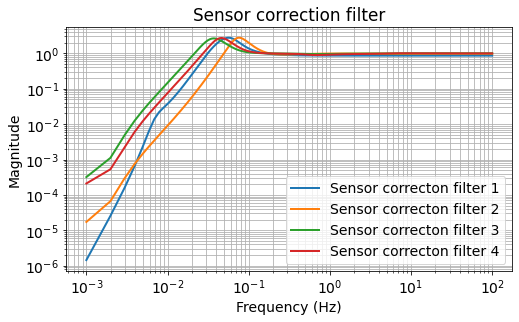

In [312]:
plt.rcParams.update({"font.size":14})
plt.figure(figsize=(8, 4.5))
plt.title("Sensor correction filter")
plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), lw=2, label="Sensor correcton filter 1")
plt.loglog(f, abs((h_sc_hinf1)(1j*2*np.pi*f)), lw=2, label="Sensor correcton filter 2")
plt.loglog(f, abs((h_sc_hinf4)(1j*2*np.pi*f)), lw=2, label="Sensor correcton filter 3")
plt.loglog(f, abs((h_sc_hinf4_2)(1j*2*np.pi*f)), lw=2, label="Sensor correcton filter 4")


plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

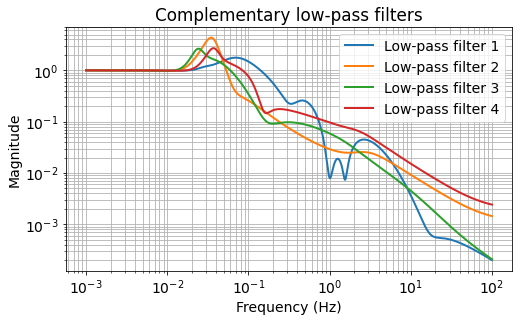

In [314]:
plt.rcParams.update({"font.size":14})
plt.figure(figsize=(8, 4.5))
plt.title("Complementary low-pass filters")
plt.loglog(f, abs(h1(1j*2*np.pi*f)), lw=2, label="Low-pass filter 1")
plt.loglog(f, abs(h1_hinf1(1j*2*np.pi*f)), lw=2, label="Low-pass filter 2")
plt.loglog(f, abs(h1_hinf4(1j*2*np.pi*f)), lw=2, label="Low-pass filter 3")
plt.loglog(f, abs(h1_hinf4_2(1j*2*np.pi*f)), lw=2, label="Low-pass filter 4")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

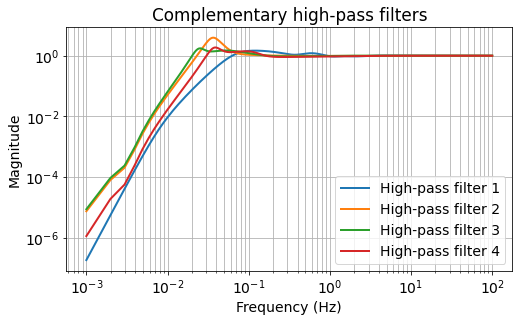

In [317]:
plt.rcParams.update({"font.size":14})
plt.figure(figsize=(8, 4.5))
plt.title("Complementary high-pass filters")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), lw=2, label="High-pass filter 1")
plt.loglog(f, abs(h2_hinf1(1j*2*np.pi*f)), lw=2, label="High-pass filter 2")
plt.loglog(f, abs(h2_hinf4(1j*2*np.pi*f)), lw=2, label="High-pass filter 3")
plt.loglog(f, abs(h2_hinf4_2(1j*2*np.pi*f)), lw=2, label="High-pass filter 4")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

In [ ]:
plt.rcParams.update({"font.size":14})
plt.figure(figsize=(8, 4.5))
plt.title("Complementary filters (sensor fusion)")
plt.loglog(f, abs(h1(1j*2*np.pi*f)), lw=2, label="Relative sensor filter")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), lw=2, label="Geophone filter")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

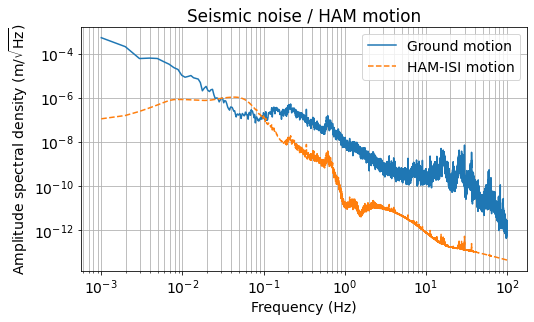

In [33]:
plt.figure(figsize=(8, 4.5))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise / HAM motion")

plt.loglog(f, seis_x2, alpha=1, label="Ground motion")
plt.loglog(f, n_super2, "--", alpha=1, label="HAM-ISI motion")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

# plt.loglog(f, seis_x1, color="C1", alpha=0.33, label="ITMX STS X 2024-02-22")
# plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
# plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

# plt.loglog(f, seis_x4, color="C1", alpha=0.33, label="ITMX STS X 2024-01-07 (Microseism)")
# plt.loglog(f, n_super4, "C1--", alpha=0.66, label="HAM motion 2024-01-07 (LIGO filters)")
# plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")
# plt.loglog(f, n_super_hinf4_2, "C5-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters, different flavor)")


plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240107.png", bbox_inches="tight")

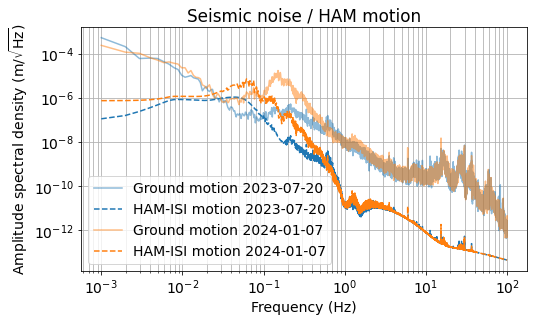

In [35]:
plt.figure(figsize=(8, 4.5))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise / HAM motion")

plt.loglog(f, seis_x2, alpha=0.5, label="Ground motion 2023-07-20")
plt.loglog(f, n_super2, "C0--", alpha=1, label="HAM-ISI motion 2023-07-20")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

# plt.loglog(f, seis_x1, color="C1", alpha=0.33, label="ITMX STS X 2024-02-22")
# plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
# plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

plt.loglog(f, seis_x4, color="C1", alpha=0.5, label="Ground motion 2024-01-07")
plt.loglog(f, n_super4, "C1--", alpha=1, label="HAM-ISI motion 2024-01-07")
# plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")
# plt.loglog(f, n_super_hinf4_2, "C5-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters, different flavor)")


plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240107.png", bbox_inches="tight")

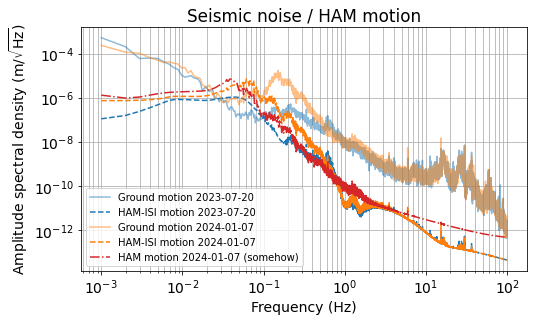

In [310]:
plt.figure(figsize=(8, 4.5))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise / HAM motion")

plt.loglog(f, seis_x2, alpha=0.5, label="Ground motion 2023-07-20")
plt.loglog(f, n_super2, "C0--", alpha=1, label="HAM-ISI motion 2023-07-20")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

# plt.loglog(f, seis_x1, color="C1", alpha=0.33, label="ITMX STS X 2024-02-22")
# plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
# plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

plt.loglog(f, seis_x4, color="C1", alpha=0.5, label="Ground motion 2024-01-07")
plt.loglog(f, n_super4, "C1--", alpha=1, label="HAM-ISI motion 2024-01-07")
# plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")
plt.loglog(f, n_super_hinf4_2, "C3-.", alpha=1, label="HAM motion 2024-01-07 (somehow)")


plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.rcParams.update({'font.size': 10})
plt.legend(loc=0)

plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240107.png", bbox_inches="tight")

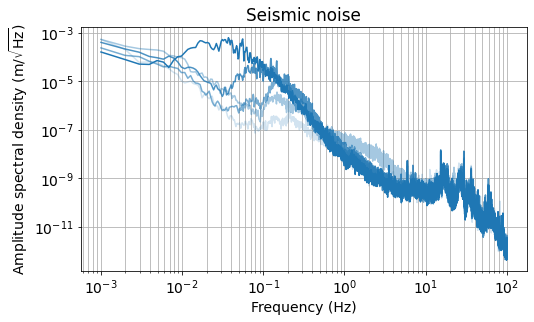

In [301]:
plt.figure(figsize=(8, 4.5))
plt.rcParams.update({'font.size': 14})
plt.title("Seismic noise")

plt.loglog(f, seis_x2, alpha=0.2, label="Ground motion 2023-07-20")
# plt.loglog(f, n_super2, "C0--", alpha=1, label="HAM-ISI motion 2023-07-20")
# plt.loglog(f, n_super_hinf, color="#5fa7f4", label="HAM motion (H-infinity filters)")

plt.loglog(f, seis_x1, color="C0", alpha=0.4, label="Ground motion 2024-02-22")
# plt.loglog(f, n_super1, "C1--", alpha=0.66, label="HAM motion 2024-02-22 (LIGO filters)")
# plt.loglog(f, n_super_hinf1, "C3-.", alpha=1, label="HAM motion 2024-02-22 (H-infinity filters)")

plt.loglog(f, seis_x4, color="C0", alpha=0.6, label="Ground motion 2024-01-07")
# plt.loglog(f, n_super4, "C1--", alpha=1, label="HAM-ISI motion 2024-01-07")
# plt.loglog(f, n_super_hinf4, "C3-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters)")
# plt.loglog(f, n_super_hinf4_2, "C5-.", alpha=1, label="HAM motion 2024-01-07 (H-infinity filters, different flavor)")
plt.loglog(f, seis_x5, color="C0", alpha=0.8, label="Ground motion 2024-01-12")
plt.loglog(f, seis_x3, color="C0", alpha=1, label="Ground motion 2024-01-01")
# plt.loglog(f, gound_rms1)


plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
# plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("isi_performance_estimation_20240107.png", bbox_inches="tight")

In [58]:
ground_rms2 = kontrol.spectral.asd2rms(f=f[(f>0.05)], asd=seis_x2[(f>0.05)], return_series=False)
ground_rms1 = kontrol.spectral.asd2rms(f=f[f>0.09], asd=seis_x1[f>0.09], return_series=False)
ground_rms4 = kontrol.spectral.asd2rms(f=f[f>0.04], asd=seis_x4[f>0.04], return_series=False)
ground_rms5 = kontrol.spectral.asd2rms(f=f[f>0.03], asd=seis_x5[f>0.03], return_series=False)
ground_rms3 = kontrol.spectral.asd2rms(f=f[f>0.005], asd=seis_x3[f>0.005], return_series=False)

In [59]:
print(ground_rms2, ground_rms1, ground_rms4, ground_rms5, ground_rms3)

1.3067480333658945e-07 6.63115829346189e-07 2.5646155946516157e-06 1.111743834490917e-05 8.012763806322706e-05


In [62]:
import scipy.io

data = scipy.io.loadmat("seismic_noise_2_year.mat")

In [85]:
seismic_noise_2_year = data["data"][0][0][1][0][0][0].flatten()

In [187]:
peaks = scipy.signal.find_peaks(seismic_noise_2_year[mask], rel_height=100)

In [183]:
peaks[0].shape

(281144,)

In [184]:
seismic_noise_2_year[mask].shape

(1030822,)

In [188]:
seismic_resample = seismic_noise_2_year[mask]
for i_peak in peaks[0]:
    seismic_resample[i_peak] = (seismic_resample[i_peak-1] + seismic_resample[i_peak+1])/2

Text(0.5, 0, 'Time (year)')

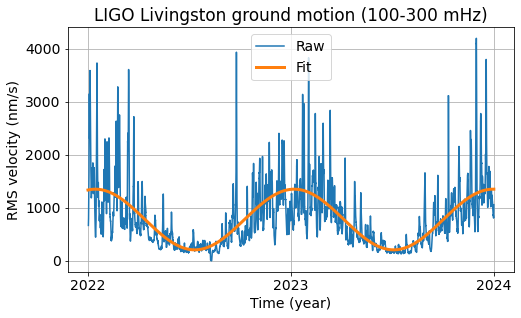

In [303]:
# mask = (seismic_noise_2_year > 0) * (seismic_noise_2_year < 5000)
# plt.plot(seismic_noise_2_year[mask])
plt.figure(figsize=(8, 4.5))
plt.title("LIGO Livingston ground motion (100-300 mHz)")
plt.rcParams.update({"font.size":14})
plt.plot(df.rolling(1000).mean(), label="Raw")
plt.plot(model(np.array(range(len(a))), *[5.72302383e+02, 1.24977400e-05, 1.33818861e+00, 7.76518730e+02]), lw=3, label="Fit")
plt.xticks([0, int(len(t)/2), len(t)], labels=[2022, 2023, 2024])
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("RMS velocity (nm/s)")
plt.xlabel("Time (year)")
# plt.plot()
# plt.vlines(peaks[0], ymin=0, ymax=1000, color="C1")

In [305]:
max(model(np.array(range(len(a))), *[5.72302383e+02, 1.24977400e-05, 1.33818861e+00, 7.76518730e+02]))

1348.821112999986

In [288]:
t = np.array(range(len(a)))

In [261]:
model(np.array(range(len(df.rolling(1000).mean()))), *[600, 0.0000125, 1.3, 750]) - np.array(df.rolling(1000).mean()).flatten()

array([         nan,          nan,          nan, ..., 295.13083546,
       294.61706663, 293.8512467 ])

In [256]:
np.array(range(len(df.rolling(1000).mean())))

array([      0,       1,       2, ..., 1026122, 1026123, 1026124])

In [278]:
a = np.array(df.rolling(1000).mean().fillna(0)).flatten()
a

array([   0.        ,    0.        ,    0.        , ..., 1054.83518959,
       1055.34903818, 1056.11493779])

In [274]:
a[0]

nan

In [277]:
df.rolling(1000).mean().fillna(0)

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1026120,1053.810493
1026121,1054.279538
1026122,1054.835190
1026123,1055.349038


In [270]:
type(np.nan)

float

In [232]:
np.array(range(123))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

In [279]:
def model(t, a, omega, phi, y):
    return a*np.sin(omega*t+phi) + y

def cost(args, array1, t, model):
    return np.mean((model(t, *args) - array1)**2)

import scipy.optimize

scipy.optimize.minimize(cost, method="nelder-mead", x0=[600, 0.0000125, 1.3, 750], args=(a, np.array(range(len(a))), model))

 final_simplex: (array([[5.72302383e+02, 1.24977400e-05, 1.33818861e+00, 7.76518730e+02],
       [5.72302448e+02, 1.24977396e-05, 1.33818878e+00, 7.76518683e+02],
       [5.72302435e+02, 1.24977401e-05, 1.33818840e+00, 7.76518743e+02],
       [5.72302442e+02, 1.24977393e-05, 1.33818889e+00, 7.76518731e+02],
       [5.72302333e+02, 1.24977401e-05, 1.33818833e+00, 7.76518677e+02]]), array([190752.46596125, 190752.46596125, 190752.46596125, 190752.46596125,
       190752.46596125]))
           fun: 190752.46596125036
       message: 'Optimization terminated successfully.'
          nfev: 199
           nit: 111
        status: 0
       success: True
             x: array([5.72302383e+02, 1.24977400e-05, 1.33818861e+00, 7.76518730e+02])

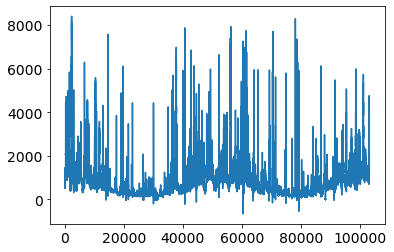

In [130]:
plt.plot(seismic_resample)

In [129]:
import scipy.signal

# seismic_resample = scipy.signal.resample(seismic_noise_2_year[mask], num=730)
seismic_resample = scipy.signal.decimate(seismic_noise_2_year[mask], q=10)

In [114]:
seismic_resample.shape

(19999,)

In [117]:
np.argmin(seismic_resample)

221

In [104]:
?np.argmin

In [191]:
import pandas

In [248]:
df = pandas.DataFrame(seismic_noise_2_year[mask])

In [198]:
df.rolling(100).mean()

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1051853,2652.130731
1051854,2613.512575
1051855,2576.643912
1051856,2548.307583
